In [3]:
import os
import sys
import time
import numpy as np 
import pandas as pd
import gc
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import json
import pickle
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk import sent_tokenize
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rouge import Rouge

import math
import os
import random
import string

# Pytorch library for training
import torch
from torch import optim

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive") 

###Import GloVe embedding

In [ ]:
# Set desired dimension of embeddings from [50, 100, 200, 300]
embed_dim = 200

# Download and unzip GloVe embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-05-27 21:36:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-27 21:36:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-27 21:36:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
# input your pre-train txt path and parse the data
embed_dim = 200
path = 'glove.6B.200d.txt'

embed_dict = {}
with open(path,'r') as f:
    lines = f.readlines()
    for l in lines:
        w = l.split()[0]
        v = np.array(l.split()[1:]).astype('float')
        embed_dict[w] = v

embed_dict['@@_unknown_@@'] = np.random.random(embed_dim)

# remove all the unnecesary files
!rm -rf glove.6B.zip
!rm -rf glove.6B.50d.txt
!rm -rf glove.6B.100d.txt
!rm -rf glove.6B.300d.txt

# check the length of the dictionary
len(embed_dict.keys())

400001

###Import data

In [6]:
%%time
data = pd.read_csv('wikihowSep.csv')
data = data[:100000]
data = data.astype(str)
rows, columns = data.shape

CPU times: user 8.25 s, sys: 800 ms, total: 9.05 s
Wall time: 9.07 s


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###Removing sentence which are too long or too short

In [8]:
contraction_map={
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd've": "how did have",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "shall'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "will't've": "will not have",
    "would've": "would have",
    "would't": "would not",
    "would't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you have all",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

def expand_contractions(sent, mapping):
    #pattern for matching contraction with their expansions
    pattern = re.compile('({})'.format('|'.join(mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    
    def expand_map(contraction):
        #using group method to access subgroups of the match
        match = contraction.group(0)
        #to retain correct case of the word
        first_char = match[0]
        #find out the expansion
        expansion = mapping.get(match) if mapping.get(match) else mapping.get(match.lower())
        expansion = first_char + expansion[1:]
        return expansion
    #using sub method to replace all contractions with their expansions for a sentence
    #function expand_map will be called for every non overlapping occurence of the pattern
    expand_sent = pattern.sub(expand_map, sent)
    return expand_sent

In [9]:
data['num_word'] = data['text'].apply(lambda x: len(str(x).split()))
num_word = np.sort(data['num_word'].values)

data['num_word_hl'] = data['headline'].apply(lambda x: len(str(x).split()))
num_word_hl = np.sort(data['num_word_hl'].values)

min_text_len = num_word[int(len(num_word)*0.1)]
max_text_len = num_word[int(len(num_word)*0.95)]

min_hl_len = num_word_hl[int(len(num_word_hl)*0.1)]

In [10]:
headline_ratio_threshold = 0.75

del_idx = []
for i in range(rows):
#     if data['num_word'][i] < max_text_len and data['num_word'][i] > min_text_len:
    if data['num_word'][i] < min_text_len:
        del_idx.append(i)
    else:
        pass
    
    if max_text_len < data['num_word'][i]:
        del_idx.append(i)
    else:
        pass

    if data['num_word_hl'][i] > headline_ratio_threshold*data['num_word'][i]:
        del_idx.append(i)
    else:
        pass
    
    if data['num_word_hl'][i] < min_hl_len:
        del_idx.append(i)
    else:
        pass

In [11]:
data_new = data.drop(del_idx)
del data

In [12]:
data_new.shape

(77774, 7)

###Removing special characters and extra comma


In [13]:
def data_loader(dataframe, target_col): 
    # Extraction from dataframe into a list
    text = [article for article in getattr(dataframe, target_col)]
    
    # Removing accented characters
    text = [unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') for sentence in text]
    
    # Expanding contractions
    text = [expand_contractions(sentence, contraction_map) for sentence in text]

    # Removing special characters
    pat1 = r'[^a-zA-z0-9.,!?\s]' 
    # pat1 = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = [re.sub(pat1, '', sentence) for sentence in text]
    
    # Removing extra commas
    pat2 = r'[.]+[\n]+[,]'
    text = [re.sub(pat2,".\n", sentence) for sentence in text]
    
    # Removing extra whitespaces and tabs
    # pat3 = r'^\s*|\s\s*'
    pat3 = r'^\s+$|\s+$'
    text = [re.sub(pat3, '', sentence).strip() for sentence in text]
    
    # Add space before '.'
    pat4 = r'\.|\?|\！|\,'
    text = [re.sub(pat4, ' ', sentence) for sentence in text]
    
    # Lowercase
    text = [sentence.lower() for sentence in text]
    
    # Tokenize
    text = [('sos ' + sentence + ' eos').split() for sentence in text]
    
    return np.array(text, dtype=object)

In [14]:
%%time
text_data = data_loader(data_new, 'text')
headline_data = data_loader(data_new, 'headline')

CPU times: user 50.7 s, sys: 329 ms, total: 51 s
Wall time: 51.2 s


In [15]:
text_data.shape, headline_data.shape

((77774,), (77774,))

In [16]:
text_train, text_test, headline_train, headline_test = train_test_split(text_data, headline_data, test_size=0.1, random_state=1)
text_train, text_dev, headline_train, headline_dev = train_test_split(text_train, headline_train, test_size=0.1, random_state=1)

In [17]:
del text_data, headline_data

In [18]:
text_train.shape

(62996,)

In [19]:
def data_sorter(text, headline): 
    headline = [y for x,y in sorted(zip(text, headline), key = lambda pair: len(pair[0]), reverse = True)]
    text = list(text)
    text.sort(key = lambda x: len(x), reverse = True)

    return np.array(text), np.array(headline)

In [20]:
text_train, headline_train = data_sorter(text_train, headline_train)
text_test,  headline_test  = data_sorter(text_test, headline_test)
text_dev,   headline_dev   = data_sorter(text_dev, headline_dev)

###Making vocabulary

In [21]:
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token
    UNK_token = 3   # Out-of-vocabulary token

    def __init__(self, name):
        self.name = name
        self.word2index = {"pad":0, "sos":1, "eos":2, "unk":3}
        self.word2count = {"pad":0, "sos":0, "eos":0, "unk":0}              
        self.index2word = {0: "pad", 1: "sos", 2: "eos", 3: "unk"}
        self.num_words = 4
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence:           
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            self.longest_sentence = sentence_len
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [22]:
text_vocabulary = Vocabulary('text')
headline_vocabulary = Vocabulary('headline')

In [23]:
for i in range(len(text_train)):
    text_vocabulary.add_sentence(text_train[i])
    for word in text_train[i]:
        text_vocabulary.add_word(word)
for i in range(len(text_dev)):
    text_vocabulary.add_sentence(text_dev[i])
    for word in text_dev[i]:
        text_vocabulary.add_word(word)
for i in range(len(headline_train)):
    headline_vocabulary.add_sentence(headline_train[i])
    for word in headline_train[i]:
        headline_vocabulary.add_word(word)
for i in range(len(headline_dev)):
    headline_vocabulary.add_sentence(headline_dev[i])
    for word in headline_dev[i]:
        headline_vocabulary.add_word(word)

In [24]:
print(len(text_vocabulary.word2index.keys()))
print(len(headline_vocabulary.word2index.keys()))

57237
18431


In [246]:
# text_dictionary
with open('text.dictionary', 'wb') as text_dictionary_file:
    pickle.dump(text_vocabulary, text_dictionary_file)

# headline_dictionary
with open('headline.dictionary', 'wb') as headline_dictionary_file:
    pickle.dump(headline_vocabulary, headline_dictionary_file)

###Making embeddings corresponding to vocabulary

In [25]:
def extract_weight(text_dictionary):
    pre_train_weight = []
    for word_index in text_dictionary.index2word.keys():
        if word_index != 0:
            word = text_dictionary.index2word[word_index]
            try:
                word_vector = embed_dict[word].reshape(1,-1)
            except:
                word_vector = embed_dict['@@_unknown_@@'].reshape(1,-1) # handle unknown word
            pre_train_weight = np.vstack([pre_train_weight,word_vector])
    
      # add for padding
        elif word_index == 0:  
            pre_train_weight = np.zeros((1, embed_dim))
    return pre_train_weight

In [26]:
%%time
pre_train_weight = extract_weight(text_vocabulary)
pre_train_weight = np.array(pre_train_weight, dtype = np.float32)

CPU times: user 11min 38s, sys: 11min 6s, total: 22min 45s
Wall time: 22min 47s


In [27]:
%%time
pre_train_weight_head = extract_weight(headline_vocabulary)
pre_train_weight_head = np.array(pre_train_weight_head, dtype = np.float32)

CPU times: user 1min 11s, sys: 1min, total: 2min 12s
Wall time: 2min 12s


In [28]:
pre_train_weight.shape, pre_train_weight_head.shape

((57237, 200), (18431, 200))

In [247]:
np.save('embedding.npy', pre_train_weight)

In [248]:
np.save('embedding_headline.npy', pre_train_weight_head)

###Transform word into index

In [29]:
def w2in(data,vocabulary,embeddings):
    data_idx = []
    lengths = []
    for i in range(len(data)):
        idx = []
        lengths.append(len(data[i]))
        for word in data[i]:
            try:
                word2index = vocabulary.to_index(word)
            except:
                word2index = vocabulary.to_index('unk')
            idx.append(word2index)
        data_idx.append(torch.tensor(idx))
    lengths = torch.tensor(lengths)
    data_pad = torch.nn.utils.rnn.pad_sequence(data_idx, batch_first=True, padding_value=0.0)
    return data_idx, data_pad, lengths

In [30]:
text_train_idx, text_train_pad, text_train_lengths = w2in(text_train,text_vocabulary, pre_train_weight)
headline_train_idx, headline_train_pad, headline_train_lengths = w2in(headline_train,headline_vocabulary, pre_train_weight)

text_dev_idx, text_dev_pad, text_dev_lengths = w2in(text_dev,text_vocabulary, pre_train_weight)
headline_dev_idx, headline_dev_pad, headline_dev_lengths = w2in(headline_dev, headline_vocabulary, pre_train_weight)

text_test_idx, text_test_pad, text_test_lengths = w2in(text_test,text_vocabulary, pre_train_weight)
headline_test_idx, headline_test_pad, headline_test_lengths = w2in(headline_test, headline_vocabulary, pre_train_weight)

In [31]:
print(text_test_pad.shape)
print(headline_train_pad.shape)
print(text_train_lengths.shape)
print(len(text_vocabulary.word2index.keys()))

torch.Size([7778, 190])
torch.Size([62996, 76])
torch.Size([62996])
57237


###Combine the data togther

In [32]:
## Zip text and headline together for dataloader
traindata = torch.utils.data.TensorDataset(text_train_pad, headline_train_pad, text_train_lengths, headline_train_lengths)
#trainlength = torch.utils.data.TensorDataset(text_train_lengths, headline_train_lengths)

devdata = torch.utils.data.TensorDataset(text_dev_pad, headline_dev_pad, text_dev_lengths, headline_dev_lengths)
#devlength = torch.utils.data.TensorDataset(text_dev_lengths, headline_dev_lengths)

testdata = torch.utils.data.TensorDataset(text_test_pad, headline_test_pad, text_test_lengths, headline_test_lengths)
#testlength = torch.utils.data.TensorDataset(text_test_lengths, headline_test_lengths)

In [249]:
np.save('text_train_pad.npy', text_train_pad)
np.save('text_train_lengths.npy', text_train_lengths)
np.save('headline_train_pad.npy', headline_train_pad)
np.save('headline_train_lengths.npy', headline_train_lengths)
np.save('text_dev_pad.npy', text_dev_pad)
np.save('text_dev_lengths.npy', text_dev_lengths)
np.save('headline_dev_pad.npy', headline_dev_pad)
np.save('headline_dev_lengths.npy', headline_dev_lengths)
np.save('text_test_pad.npy', text_test_pad)
np.save('text_test_lengths.npy', text_test_lengths)
np.save('headline_test_pad.npy', headline_test_pad)
np.save('headline_test_lengths.npy', headline_test_lengths)

In [221]:
# test data
torch.save(testdata, 'testdata_zip.pt')

In [33]:
## Set batch size and split data after padding to batches
def batch_dataloader(data, Batch_size):
    data_dataloader = torch.utils.data.DataLoader(data, batch_size=Batch_size, shuffle=False, num_workers=0)
#     for i in data_dataloader:
#         i = torch.transpose(i, 0 ,1)
#         print(data_dataloader)
    
    return data_dataloader

###Set batch size

In [35]:
## Training data batching
trainloader = batch_dataloader(traindata, 100)
#trainlen = batch_dataloader(trainlength, 15)

devloader = batch_dataloader(devdata, 50)
#devlen = batch_dataloader(devlength, 2)

testloader = batch_dataloader(testdata, 50)
#testlen = batch_dataloader(testlength, 2)

In [36]:
## Transpose dataset for training
text_testrun, hl_testrun, text_len, hl_len = next(iter(trainloader))
#text_len, hl_len = next(iter(trainlen))

text_testrun = torch.transpose(text_testrun, 0 ,1)
hl_testrun = torch.transpose(hl_testrun, 0 ,1)

In [37]:
text_testrun.shape

torch.Size([202, 100])

In [ ]:
# text_dictionary
with open('Data/text.dictionary', 'rb') as text_dictionary_file: #for S2S and S2S+GAN
    text_vocabulary = pickle.load(text_dictionary_file)
# headline_dictionary
with open('Data/headline.dictionary', 'rb') as headline_dictionary_file: #for S2S and S2S+GAN
    headline_vocabulary = pickle.load(headline_dictionary_file)


###Set parameters

In [38]:
### Set parameters
input_size = int(len(text_vocabulary.index2word.keys()))
output_size = int(len(headline_vocabulary.index2word.keys()))

enc_emb_size = 200
dec_emb_size = 200
hid_size = 256

n_layers = 2
enc_dropout = 0.1
dec_dropout = 0.1

###Encoder and Decoder

In [39]:
class Encoder1(nn.Module):
    def __init__(self, input_size, emb_size, hid_size, n_layers, dropout, embeddings):
        super().__init__()
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embeddings
        self.lstm = nn.LSTM(emb_size, hid_size, n_layers, dropout=dropout)
        self.linear = nn.Linear
        
#         self.lstm = nn.LSTM(emb_size, hid_size, n_layers, dropout=dropout, bidirectional = True)
        

    def forward(self, x, x_length):
        embedded = torch.tensor([[self.embedding[i] for i in x[:, seq]]for seq in range(x.shape[1])]).permute(1, 0, 2)
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_length.numpy(),batch_first=False)
        outputs, (hidden, cell) = self.lstm(embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return hidden, cell

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_size, emb_size, hid_size, n_layers, dropout, embeddings):
        super().__init__()
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embeddings
        self.lstm = nn.LSTM(emb_size, hid_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_size, output_size, bias = True)

    def forward(self, output, hidden, cell):
        embedded = torch.tensor([self.embedding[x] for x in output]).float().unsqueeze(0)

        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        prediction = self.out(outputs.squeeze(0))
        return prediction, hidden, cell

###Sequence to Sequence

In [41]:
class Seq2Seq1(nn.Module):
    def __init__(self, encoder: Encoder1, decoder: Decoder, device: torch.device, embeddings):
        super().__init__()
        self.embedding = embeddings
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, text_batch, text_batch_len, headline_batch, teacher_forcing_ratio: float=0.5):
        max_len, batch_size = headline_batch.shape
        headline_vocab_size = self.decoder.output_size

        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, headline_vocab_size).to(self.device)

        # last hidden & cell state of the encoder is used as the decoder's initial hidden state
        hidden, cell = self.encoder(text_batch, text_batch_len)
        
        hl_batch_i = headline_batch[0]
        
        for i in range(1, max_len):
            prediction, hidden, cell = self.decoder(hl_batch_i, hidden, cell)
            outputs[i] = prediction

            if random.random() < teacher_forcing_ratio:
                hl_batch_i = headline_batch[i]
            else:
                hl_batch_i = prediction.argmax(1)

        return outputs

###call for Seq2Seq

In [42]:
encoder = Encoder1(input_size, enc_emb_size, hid_size, n_layers, enc_dropout, pre_train_weight)
decoder = Decoder(output_size, dec_emb_size, hid_size, n_layers, dec_dropout, pre_train_weight_head)
seq2seq = Seq2Seq1(encoder, decoder, device, pre_train_weight)
seq2seq

Seq2Seq1(
  (encoder): Encoder1(
    (lstm): LSTM(200, 256, num_layers=2, dropout=0.1)
  )
  (decoder): Decoder(
    (lstm): LSTM(200, 256, num_layers=2, dropout=0.1)
    (out): Linear(in_features=256, out_features=18431, bias=True)
  )
)

###Training and Evaluate

In [43]:
optimizer = optim.Adam(seq2seq.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = 0) 

In [44]:
def train1(seq2seq, trainloader, optimizer, criterion):
    seq2seq.train()

    epoch_loss = 0
    for text_batch, hl_batch, text_len, hl_len in trainloader:
        text_batch = torch.transpose(text_batch, 0, 1)
        hl_batch = torch.transpose(hl_batch, 0, 1)
        
        ## send to cuda
        #text_batch = text_batch.to(device)
        #hl_batch = hl_batch.to(device)
        optimizer.zero_grad()
        
        text_batch = text_batch[:text_len.max()].to(device)
        hl_batch = hl_batch[:hl_len.max()].to(device)
                                 
        outputs = seq2seq(text_batch, text_len, hl_batch)
        outputs_flatten = outputs[1:].view(-1, outputs.shape[-1])
        
        hl_flatten = hl_batch[1:].reshape(-1)
        loss = criterion(outputs_flatten, hl_flatten)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(trainloader)

In [45]:
def evaluate1(seq2seq, trainloader, criterion):
    seq2seq.eval()

    epoch_loss = 0
    with torch.no_grad():
        for text_batch, hl_batch, text_len, hl_len in trainloader:
            text_batch = torch.transpose(text_batch, 0, 1)
            hl_batch = torch.transpose(hl_batch, 0, 1)

            ## send to cuda
            #text_batch = text_batch.to(device)
            #hl_batch = hl_batch.to(device)
            
            text_batch = text_batch[:text_len.max()].to(device)
            hl_batch = hl_batch[:hl_len.max()].to(device)
            # teacher forcing not used
            outputs = seq2seq(text_batch, text_len, hl_batch, teacher_forcing_ratio=0) 
            outputs_flatten = outputs[1:].view(-1, outputs.shape[-1])
            
            hl_flatten = hl_batch[1:].reshape(-1)
            loss = criterion(outputs_flatten, hl_flatten)
            epoch_loss += loss.item()

    return epoch_loss / len(trainloader)

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
num_epoch = 10
best_valid_loss = float('inf')
e11 = []
e21 = []

for epoch in range(num_epoch):    
    start_time = time.time()
    train_loss = train1(seq2seq, trainloader, optimizer, criterion)
    e11.append(train_loss)
    valid_loss = evaluate1(seq2seq, devloader, criterion)
    e21.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'tut1-model2.pt')

    # it's easier to see a change in perplexity between epoch as it's an exponential
    # of the loss, hence the scale of the measure is much bigger
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 86m 42s
	Train Loss: 6.180 | Train PPL: 483.218
	 Val. Loss: 6.107 |  Val. PPL: 449.108
Epoch: 02 | Time: 80m 31s
	Train Loss: 5.810 | Train PPL: 333.469
	 Val. Loss: 6.053 |  Val. PPL: 425.283
Epoch: 03 | Time: 77m 41s
	Train Loss: 5.604 | Train PPL: 271.536
	 Val. Loss: 5.954 |  Val. PPL: 385.260
Epoch: 04 | Time: 76m 43s
	Train Loss: 5.348 | Train PPL: 210.181
	 Val. Loss: 5.797 |  Val. PPL: 329.258
Epoch: 05 | Time: 74m 23s
	Train Loss: 5.156 | Train PPL: 173.405
	 Val. Loss: 5.740 |  Val. PPL: 311.046
Epoch: 06 | Time: 74m 22s
	Train Loss: 4.993 | Train PPL: 147.330
	 Val. Loss: 5.701 |  Val. PPL: 299.087
Epoch: 07 | Time: 74m 41s
	Train Loss: 4.848 | Train PPL: 127.431
	 Val. Loss: 5.636 |  Val. PPL: 280.362
Epoch: 08 | Time: 78m 19s
	Train Loss: 4.704 | Train PPL: 110.419
	 Val. Loss: 5.628 |  Val. PPL: 278.098
Epoch: 09 | Time: 80m 56s
	Train Loss: 4.585 | Train PPL:  98.006
	 Val. Loss: 5.606 |  Val. PPL: 272.053
Epoch: 10 | Time: 77m 4s
	Train Loss: 4.494 | 

In [48]:
for epoch in range(10,12):    
    start_time = time.time()
    train_loss = train1(seq2seq, trainloader, optimizer, criterion)
    e11.append(train_loss)
    valid_loss = evaluate1(seq2seq, devloader, criterion)
    e21.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'tut1-model2.pt')

    # it's easier to see a change in perplexity between epoch as it's an exponential
    # of the loss, hence the scale of the measure is much bigger
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 11 | Time: 81m 6s
	Train Loss: 4.398 | Train PPL:  81.280
	 Val. Loss: 5.612 |  Val. PPL: 273.708
Epoch: 12 | Time: 83m 3s
	Train Loss: 4.312 | Train PPL:  74.614
	 Val. Loss: 5.602 |  Val. PPL: 271.084


In [62]:
seq2seq.load_state_dict(torch.load('tut1-model2.pt'))#Call the model with the best loss of validation

<All keys matched successfully>

###Outputs

Note:
1.   Embedding name for the training vocabulary: pre_train_weight.
2.   seq2seq(text_batch, text_len, hl_batch, teacher_forcing_ratio=0)\
text_batch = [max_length_text(each batch), batch_size]\
text_len = real length of each text in the batch (a list)\
hl_batch = [max_length_hl(each batch), batch_size]
3.   Outputs is a list with outputs of S2S as the element.
     [max_length_hl(each batch), batch_size, vocabulary_size]
4.   Predict is a list with prediction of each batch.
     [max_length_hl, batch_size]
5.   e1 and e2 are the collection of the training loss and validation loss.



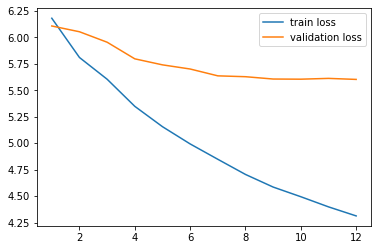

In [56]:
n = range(1,13)
plt.plot(n,e11)
plt.plot(n,e21)
plt.legend(['train loss','validation loss'])
#plt.savefig('Seq-to-Seq256.jpg')

In [57]:
e11 = np.array(e11)
np.save('train loss 256.npy', e11)

In [58]:
e21 = np.array(e21)
np.save('val loss 256.npy', e21)

In [63]:
outputs = []
target = []
for text_batch, hl_batch, text_len, headline_len in testloader:
    text_batch = torch.transpose(text_batch, 0, 1) 
    hl_batch = torch.transpose(hl_batch, 0, 1)
    text_batch = text_batch[:text_len.max()]
    hl_batch = hl_batch[:headline_len.max()]
    with torch.no_grad():
        a = seq2seq(text_batch, text_len, hl_batch, teacher_forcing_ratio=0)
        a = a.argmax(2)
    for i in range(a.shape[1]):
        outputs.append(' '.join([headline_vocabulary.index2word[j] for j in a[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)]))
        target.append(' '.join([headline_vocabulary.index2word[j] for j in hl_batch[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)])) 

In [66]:
rouge = Rouge()
r1 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs, target)]
r2 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs, target)]

In [67]:
rouge1 = np.array(r1).mean()
rouge2 = np.array(r2).mean()

In [68]:
rouge1,rouge2

(0.13478372918700593, 0.030525662924277365)